<a href="https://colab.research.google.com/github/ayberkozcan/pytorch-computer-vision/blob/main/Handwritten_Digits_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Digits Classification Using PyTorch

## Importing Libraries

In [40]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading MNIST Dataset

In [42]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
)

## Recognizing our Dataset

In [43]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

There are 60.000 training samples and 10.000 testing samples.

In [44]:
# Let's see classes
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape: torch.Size([1, 28, 28])


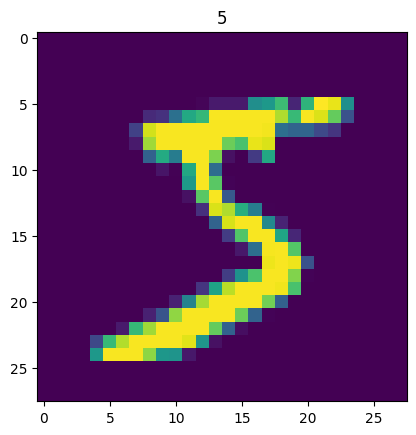

In [45]:
image, label = train_data[0]

print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)
plt.show()

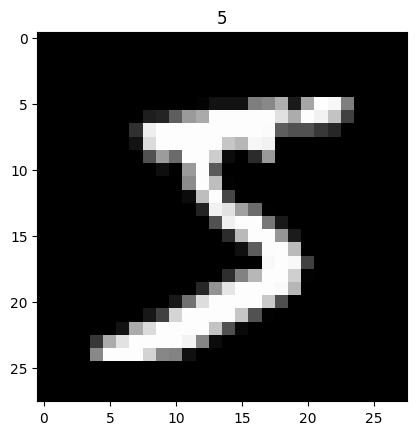

In [46]:
# Let's turn the image into grayscale
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
plt.show()

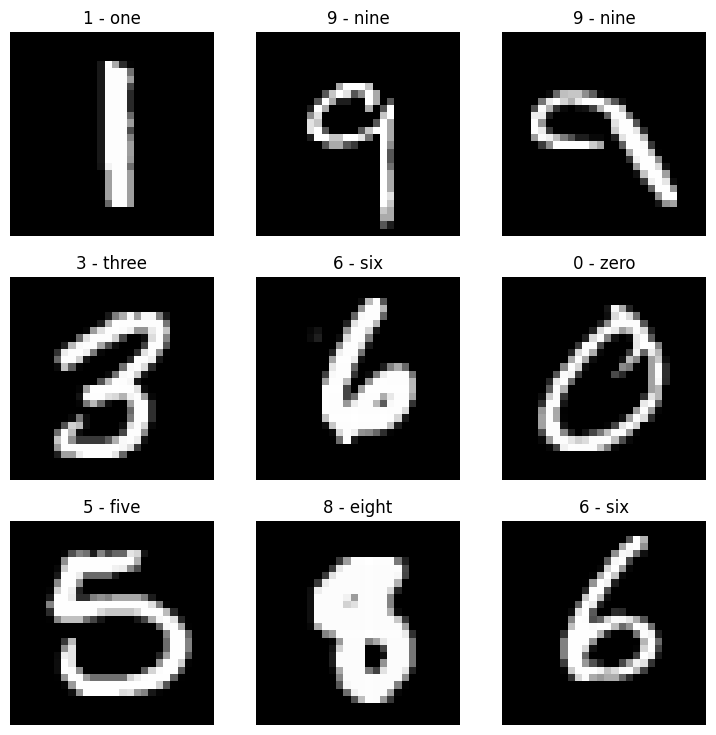

In [47]:
# Let's plot more images
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

In [48]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=False
)

In [49]:
print(f"Length of train dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Length of train dataloader: 938
Length of test dataloader: 157


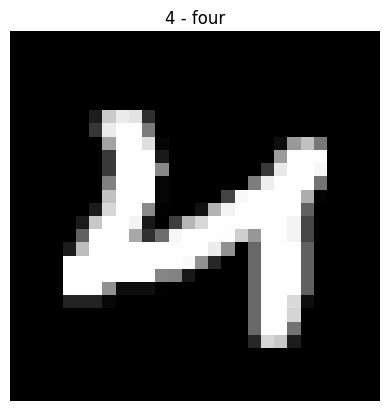

In [50]:
# Let's see a sample
train_features_batch, train_labels_batch = next(iter(train_dataloader))

random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");

## Building a Model

In [51]:
class MNISTModel_0(nn.Module):
  def __init__(self, input_shape=784, hidden_units=128, output_shape=10):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [52]:
model_0 = MNISTModel_0(
    input_shape=784,
    hidden_units=128,
    output_shape=len(class_names)
)
model_0

MNISTModel_0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [53]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists!")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists!


In [54]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

## Measuring Time Function

We are going to measure time for different models.

In [55]:
from timeit import default_timer as timer

def measure_time(start, end):
  total_time = end - start
  return total_time

## Training Loop and Training a Model

In [71]:
from tqdm.auto import tqdm

train_time_start = timer()

epochs = 10

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    train_acc += accuracy_fn(
        y_true=y,
        y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = model_0(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss

      accuracy = accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
      test_acc += accuracy

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

  results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
  results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
  results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

# Measuring time
train_time_end = timer()
total_time_on_model_0 = measure_time(train_time_start, train_time_end)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.00668 | Train Accuracy: 99.96%, Test Loss: 0.06850 | Test Accuracy: 97.95%

Epoch: 1
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.00629 | Train Accuracy: 99.97%, Test Loss: 0.06756 | Test Accuracy: 97.96%

Epoch: 2
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.00599 | Train Accuracy: 99.98%, Test Loss: 0.06870 | Test Accuracy: 98.11%

Epoch: 3
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.00581 | Train Accuracy: 99.97%, Test Loss: 0.07023 | Test Accuracy: 97.97%

Epoch: 4
------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.00546 | Train Accuracy: 99.98%, Test Loss: 0.06869 | Test Accuracy: 98.08%

Epoch: 5
------
Looked at 0/60000 s

In [72]:
loss = results['train_loss']
test_loss = results['test_loss']

accuracy = results['train_acc']
test_accuracy = results['test_acc']

epochs = range(len(results['train_loss']))

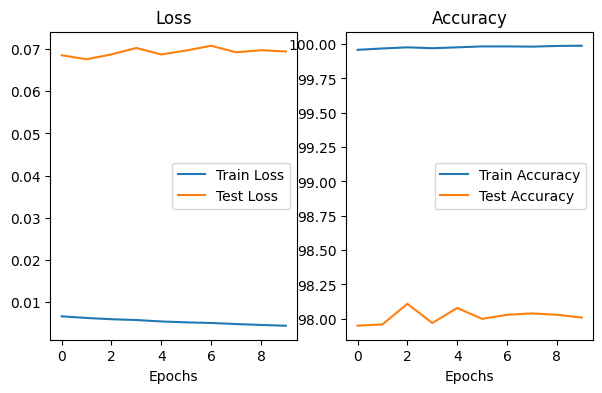

In [75]:
plt.figure(figsize=(7, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

## Confusion Matrix

## Making Prediction on my Handwritten Digit Image